Based on this youtube video : https://www.youtube.com/watch?v=SSW9LzOJSus

# Load dependecy

In [3]:
!pip install tensorflow>2.4.1 tensorflow-gpu>2.4.1 opencv-python matplotlib

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

# 1. Load Model

In [3]:
interpreter = tf.lite.Interpreter(model_path = 'lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

# 2. Make Detections

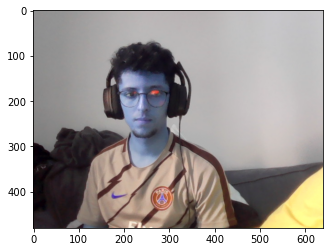

In [8]:
plt.imshow(frame)

In [15]:
frame.shape

(480, 640, 3)

In [38]:
cap = cv2.VideoCapture(0) # connect to webcam, change number if no cam detected
#cap = cv2.VideoCapture('Video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image to 192x192x3
    img = frame.copy() # copy the last frame
    # from (1, 480, 640, 3) -> (1, 192, 192, 3)
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32) # data absolutely need to be in float32
    
    # Setup input and output. Give a dict
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    #Make predictions
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image)) # input image to sensor
    interpreter.invoke() #Run 'Inference' mode
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index']) #get inference result
    #print(keypoints_with_scores)
    
    #Rendering
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    
    cv2.imshow('Test MoveNet', frame) # FrameName
    
    # Break the loop if Q key is pressed
    if cv2.waitKey(10) & 0xFF==ord('q') :
        break
cap.release()
cv2.destroyAllWindows()

In [21]:
print(keypoints_with_scores[0][0]) # 1x1x17x3 shape, normalized
print(keypoints_with_scores[0][0][0]) # Nose : y, x, confidence

[[0.43050396 0.40614793 0.7917076 ]
 [0.39641178 0.44586143 0.6853807 ]
 [0.38904476 0.36658692 0.83663356]
 [0.43630955 0.483896   0.58031476]
 [0.41864443 0.3064666  0.41868705]
 [0.622483   0.59286    0.85593635]
 [0.61064124 0.21815658 0.7751215 ]
 [0.87428445 0.62908155 0.38270533]
 [0.8740913  0.16892383 0.39656106]
 [0.8669898  0.39458928 0.1053774 ]
 [0.84556425 0.21173452 0.05412909]
 [0.9447121  0.46009263 0.04598356]
 [0.9332355  0.260585   0.02542329]
 [0.8779537  0.612236   0.03185261]
 [0.8414444  0.20315516 0.04446499]
 [0.8700448  0.38860425 0.02223776]
 [0.8530781  0.28267628 0.0162383 ]]
[0.43050396 0.40614793 0.7917076 ]


A float32 tensor of shape [1, 1, 17, 3].

    - The first two channels of the last dimension represents the yx coordinates (normalized to image frame, i.e. range in [0.0, 1.0]) of the 17 keypoints (in the order of: [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]).

    - The third channel of the last dimension represents the prediction confidence scores of each keypoint, also in the range [0.0, 1.0].


# 3. Draw Keypoints

In [28]:
def draw_keypoints(frame, keypoints, confidence_threshhold) : 
    y, x, c = frame.shape #Webcam Height, length, Channel
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1])) # last column = float
    
    for kp in shaped :
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshhold :
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1)    
      

# 3. Draw Edges connections

In [30]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [33]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)